# 手刻基本Naive Bayes模型

#### 學習重點：理解單純貝氏模型原理

---

In [1]:
import re
import numpy as np
import math
import os
import glob
import codecs

from collections import defaultdict
from collections import Counter

def tokenize(message):
    message=message.lower()
    all_words=re.findall("[a-z0-9]+",message)
    return set(all_words)

### 讀入資料並分割為 train/testset

In [2]:
X = []
Y = []
paths =[r'spam_data/spam', r'spam_data/easy_ham', r'spam_data/hard_ham'] 
for path in paths:
    for fn in glob.glob(path+"/*"):
        if "ham" not in fn:
            is_spam = True
        else:
            is_spam = False
        #codecs.open可以避開錯誤，用errors='ignore'
        with codecs.open(fn,encoding='utf-8', errors='ignore') as file:
            for line in file:
                #這個line的開頭為Subject:
                if line.startswith("Subject:"):
                    subject=re.sub(r"^Subject:","",line).strip()
                    X.append(subject)
                    Y.append(is_spam)

In [3]:
from sklearn.model_selection import train_test_split
# random_state 是為了讓各為學員得到相同的結果，平時可以移除
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [4]:
train_data = []
test_data = []

for x_, y_ in zip(X_train, y_train):
    train_data.append([x_, y_])

for x_, y_ in zip(X_test, y_test):
    test_data.append([x_, y_])

---

### defaultdict用法示範

In [5]:
from collections import defaultdict

mess='This is our first time in Taiwan,,,,, such a beautiful contury'

counts=defaultdict(lambda:[0,0])
counts['you'][0]+=1
counts['hi'][0]+=1
counts['hi'][1]+=2
counts['no'][1]+=1
counts['no'][0]+=8
print('dic : {}'.format(counts))
print('you : {}'.format(counts['you']))

dic : defaultdict(<function <lambda> at 0x000001BBA3A18948>, {'you': [1, 0], 'hi': [1, 2], 'no': [8, 1]})
you : [1, 0]


### 創造一個字典，裡面是{'hi': [1, 0]}，對應第一個數字是是垃圾郵件的次數，對應第二個數字是不是垃圾郵件的次數

In [6]:
def count_words(training_set):
    counts=defaultdict(lambda:[0,0])
    for message,is_spam in training_set:
        for word in tokenize(message):
            counts[word][0 if is_spam else 1]+=1
    return counts

---

## 計算 p(w|spam) / p(w|non_spam)
* 其中K為超參數，為了確保分母/分子皆不為0

In [7]:
def word_probabilities(counts,total_spams,total_non_spams,k=0.5):
    #獲得三組數據，分別為w這個字，p(w|spam)，p(w|non_spam)
    #counts[w][0]=spam,counts[w][1]=non_spam
    return [(w,(counts[w][0]+k)/(total_spams+2*k),(counts[w][1]+k)/(total_non_spams+2*k)) for w in counts]

---

## 計算貝氏結果

In [8]:
# spam_probability(self.word_probs,message, self.is_spam_probability, self.is_not_spam_probability)
def spam_probability(word_probs, message, is_spam_probability, is_not_spam_probability):
    #先把mail的文字處理一下
    message_words=tokenize(message)
    #初始化值
    log_prob_if_spam=log_prob_if_not_spam=0.0
    #將w這個字，p(w|spam)，p(w|non_spam)依序引入
    for word,prob_if_spam,prob_if_not_spam in word_probs:
        if word in message_words:
            #假如這個字有在這個mail中出現
            #把他的p(w|spam)轉log值加上log_prob_if_spam
            log_prob_if_spam=log_prob_if_spam+math.log(prob_if_spam)
            #把他的p(w|non_spam)轉log值加上log_prob_if_not_spam
            log_prob_if_not_spam=log_prob_if_not_spam+math.log(prob_if_not_spam)
        else:
            #如果沒出現log_prob_if_spam➕上得值就是1-p(w|spam)也就是這封信是垃圾郵件但是w這個字卻沒在裡面
            log_prob_if_spam=log_prob_if_spam+math.log(1-prob_if_spam)
            log_prob_if_not_spam=log_prob_if_not_spam+math.log(1-prob_if_not_spam)
    log_prob_if_spam = log_prob_if_spam + math.log(is_spam_probability)
    log_prob_if_not_spam = log_prob_if_not_spam + math.log(is_not_spam_probability)
    
    #把+起來的值轉成exp再算NaiveBayes
    prob_if_spam=math.exp(log_prob_if_spam)
    prob_if_not_spam=math.exp(log_prob_if_not_spam)
    #貝氏
    return prob_if_spam/(prob_if_spam+prob_if_not_spam)

---

### 打包整個模型

In [9]:
class NaiveBayesClassifier:
    def __init__(self,k=0.5):
        self.k=k
        self.word_probs=[]
    def train(self,training_set):
        #訓練的資料格式為(message,is_spam)
        #所有垃圾郵件的數量
        num_spams=len([is_spam for message,is_spam in training_set if is_spam])
        #所有不是垃圾郵件的數量
        num_non_spams=len(training_set)-num_spams
        
        self.is_spam_probability = num_spams/(num_spams+num_non_spams)
        self.is_not_spam_probability = num_non_spams/(num_spams+num_non_spams)
        #把training_set裡面的所有字體轉成('Bad',num_is_spam,num_not_spam)
        word_counts=count_words(training_set)
        self.word_probs=word_probabilities(word_counts,num_spams,num_non_spams,self.k)
    def classify(self,message):
        return spam_probability(self.word_probs, message, self.is_spam_probability, self.is_not_spam_probability)

---

### Fit 訓練集

In [10]:
classifier=NaiveBayesClassifier()

In [11]:
classifier.train(train_data)

### 預測

In [12]:
classified=[(subject,is_spam,classifier.classify(subject)) for subject,is_spam in test_data]
counts=Counter((is_spam,spam_probability>0.5) for _,is_spam,spam_probability in classified)

In [13]:
counts

Counter({(False, False): 579,
         (True, False): 36,
         (True, True): 62,
         (False, True): 8})

In [14]:
#precision=counts[(True, True)]/(counts[(True, True)]+counts[(False, True)])
#recall=counts[(True, True)]/(counts[(True, True)]+counts[(True, False)])
precision=counts[(True, True)]/(counts[(True, True)]+counts[(True, False)])
recall=counts[(True, True)]/(counts[(True, True)]+counts[(False, True)])
binary_accuracy = (counts[(True, True)]+counts[(False, False)])/(counts[(False, True)]+counts[(False, False)]+counts[(True, True)]+counts[(True, False)])
print('accuracy : {:.2f}%'.format(binary_accuracy*100))
print('precision : {:.2f}%'.format(precision*100))
print('recall : {:.2f}%'.format(recall*100))

accuracy : 93.58%
precision : 63.27%
recall : 88.57%


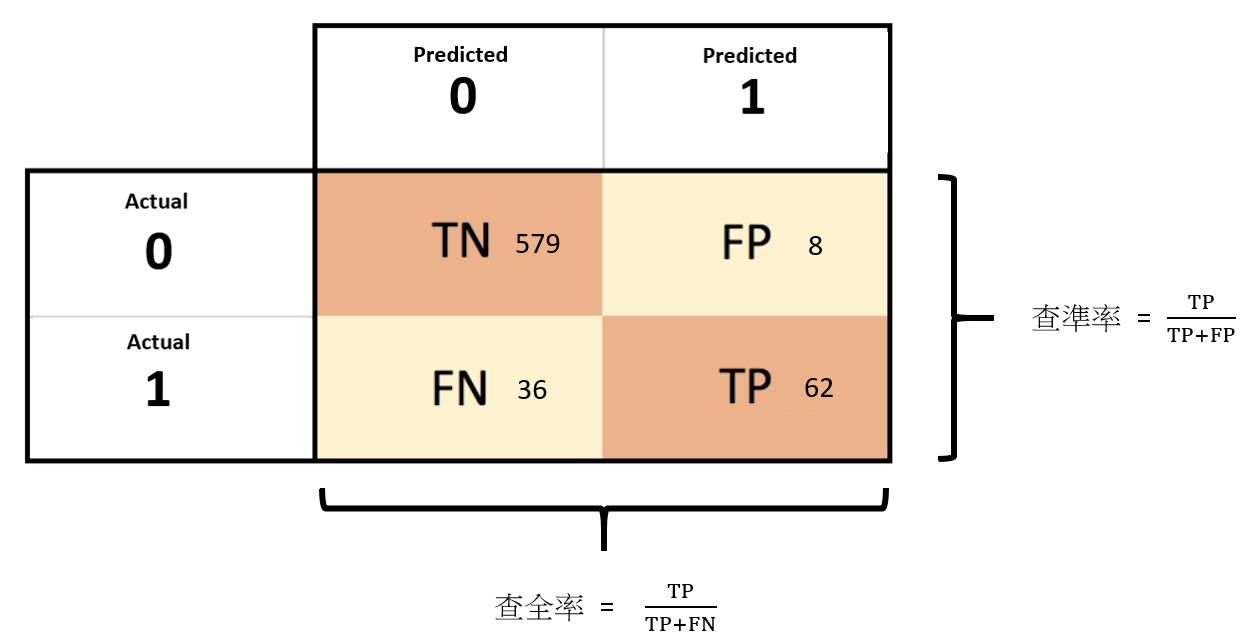

In [15]:
from IPython.display import Image
Image(filename='confusion_matrix.png')